In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pymc as pm

In [ ]:
df = pd.read_csv('../data/BrentOilPrices.csv')


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [13]:
df.isnull


<bound method DataFrame.isnull of             Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
...           ...
2022-11-08  96.85
2022-11-09  93.05
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59

[9011 rows x 1 columns]>

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date')

# Preprocess the data
df['Price'] = df['Price'].interpolate()

C:\Users\hp\AppData\Local\Temp\ipykernel_38380\2268312663.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [6]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


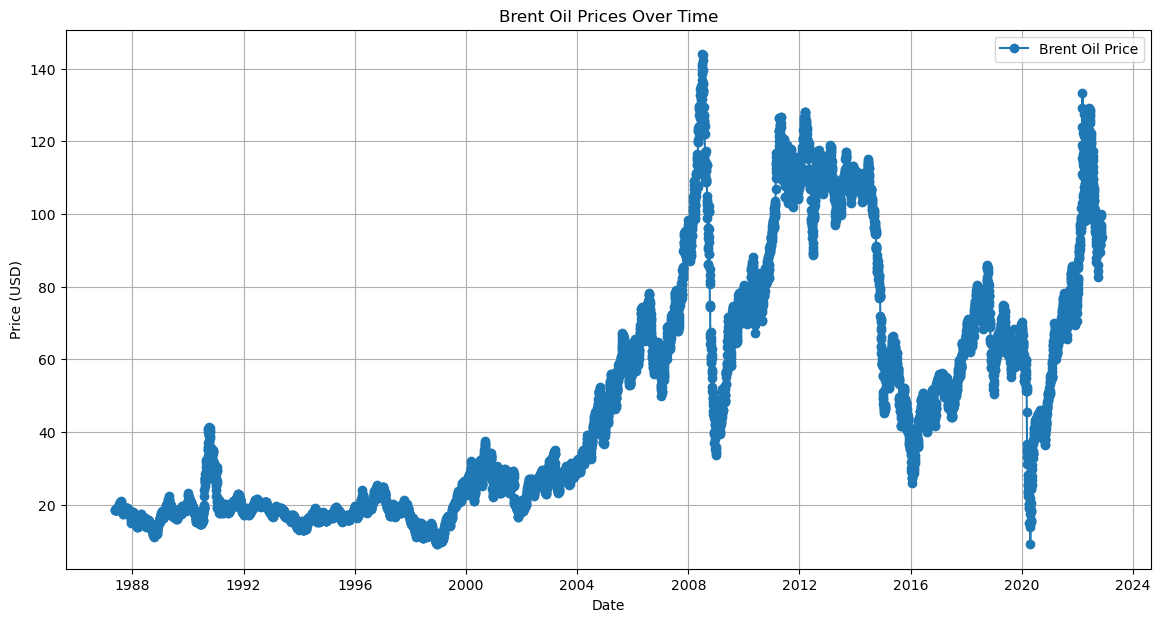

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()


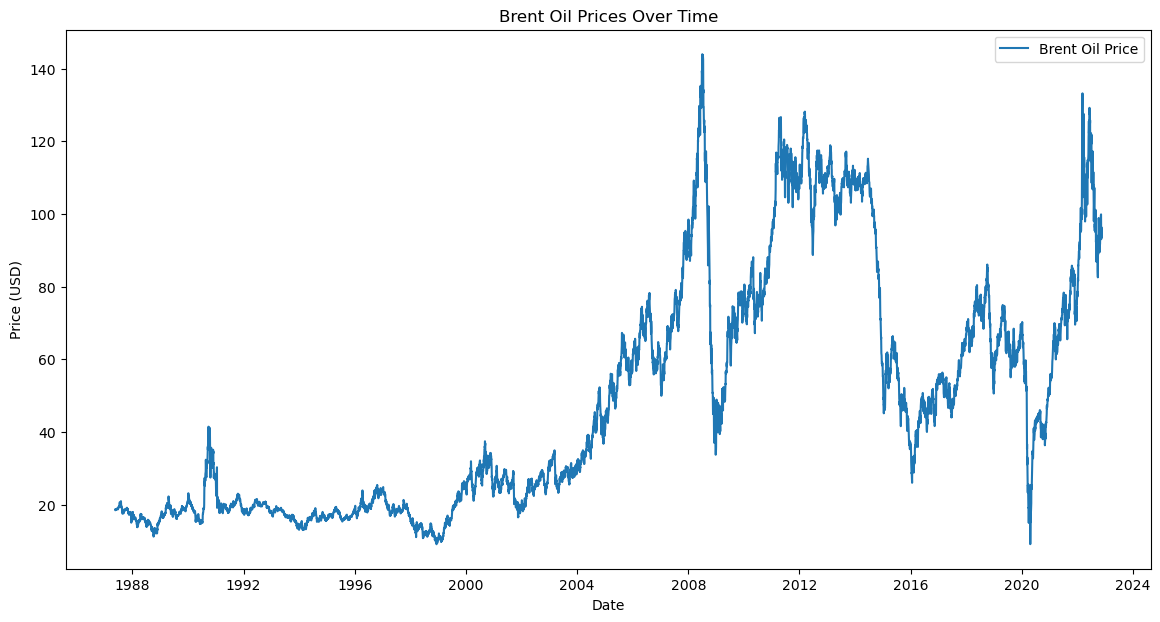

In [7]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time')
plt.legend()
plt.show()

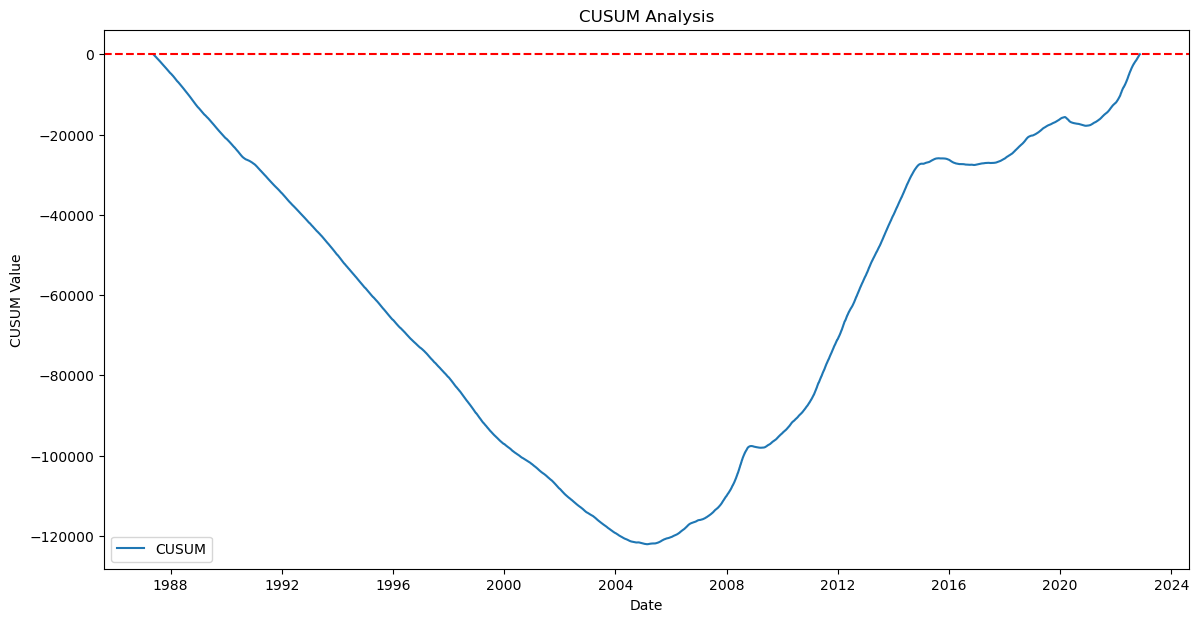

In [8]:

# CUSUM method
mean_price = df['Price'].mean()
cusum = np.cumsum(df['Price'] - mean_price)
plt.figure(figsize=(14, 7))
plt.plot(df.index, cusum, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Analysis')
plt.legend()
plt.show()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mean_prior]
>Metropolis: [change_point]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2971 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


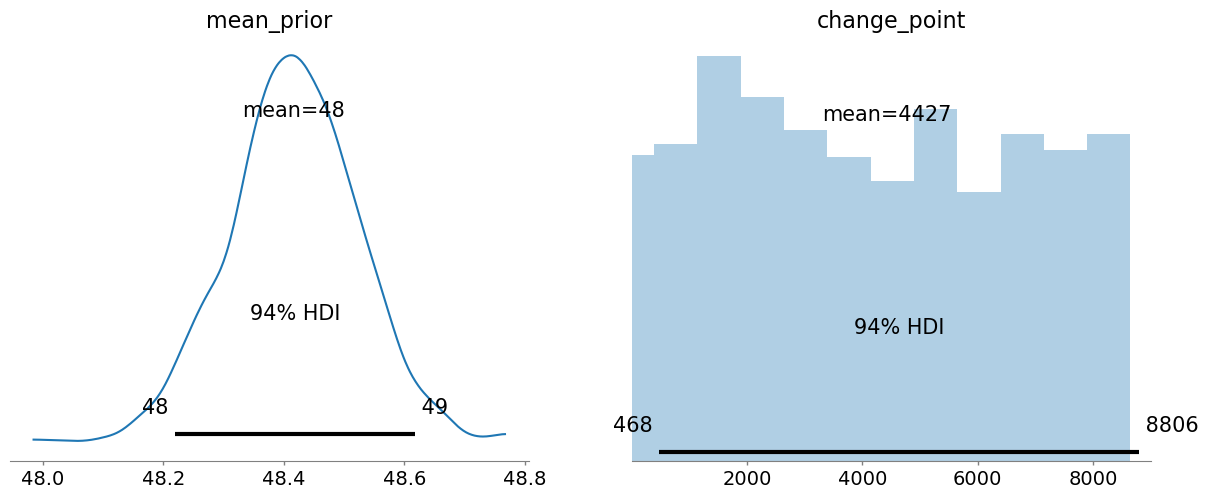

In [9]:

# Bayesian Change Point Detection using PyMC3
with pm.Model() as model:
    # Priors
    mean_prior = pm.Normal('mean_prior', mu=mean_price, sigma=10)
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(df)-1)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mean_prior, sigma=10, observed=df['Price'])

    # Inference
    trace = pm.sample(1000, tune=1000, cores=2)

# Plot results
pm.plot_posterior(trace)
plt.show()

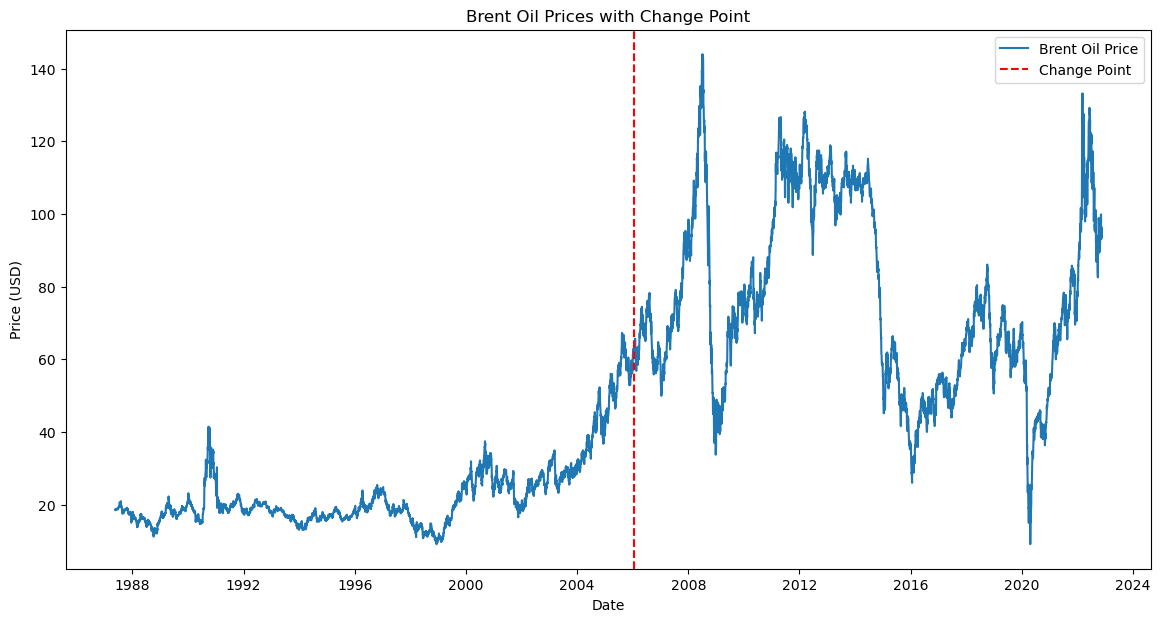

In [10]:
change_point_index = 4753

# Plot the data with the change point
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.axvline(x=df.index[change_point_index], color='red', linestyle='--', label='Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Change Point')
plt.legend()
plt.show()

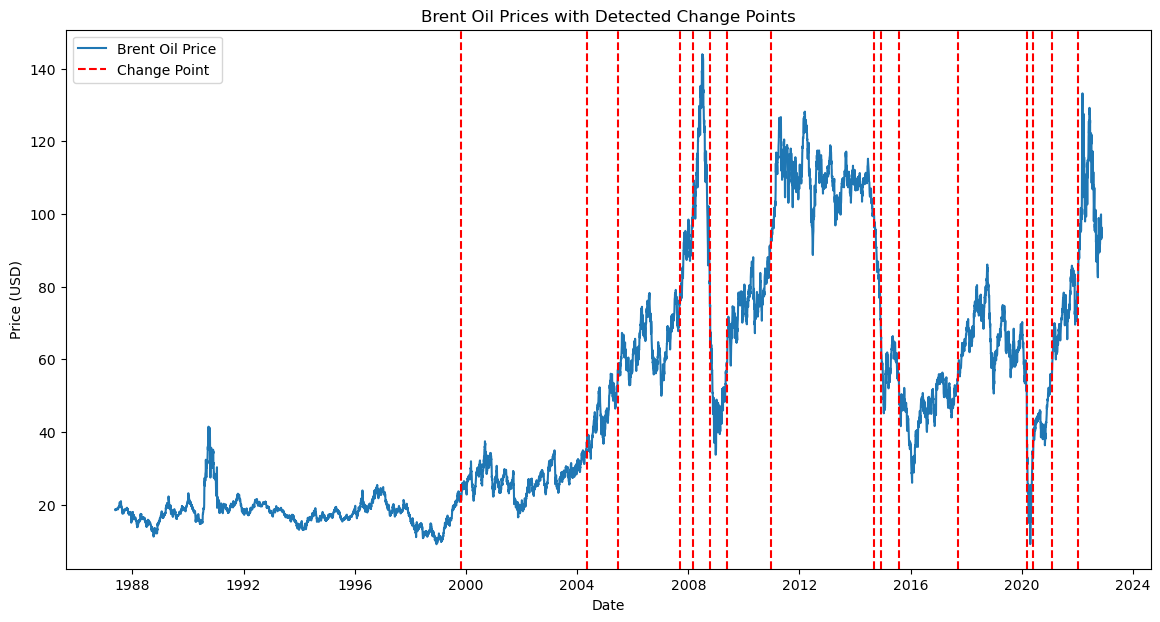

In [11]:
price_array = df['Price'].values
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_array)
change_points = algo.predict(pen=20)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.show()

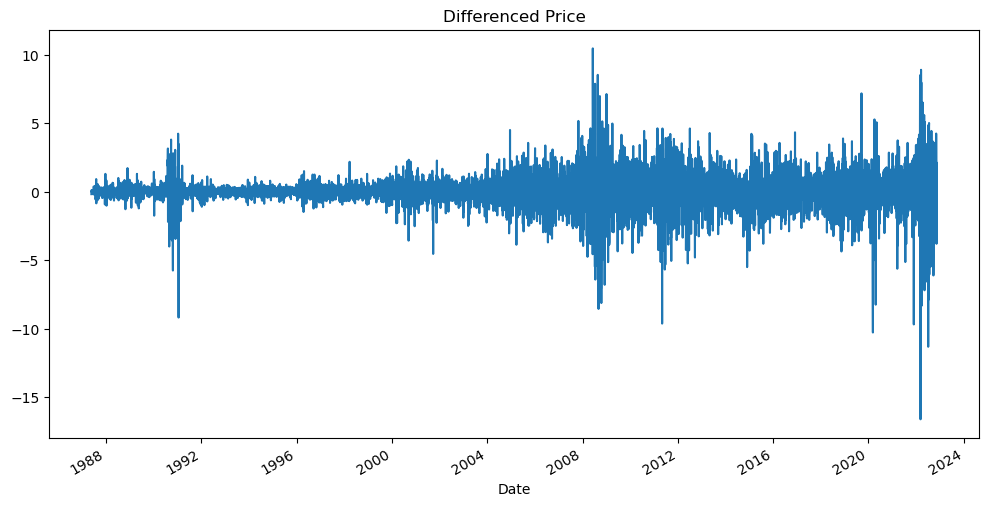

In [15]:
df['Price_diff'] = df['Price'] - df['Price'].shift(1)
df['Price_diff'].dropna().plot(figsize=(12, 6))
plt.title('Differenced Price')
plt.show()


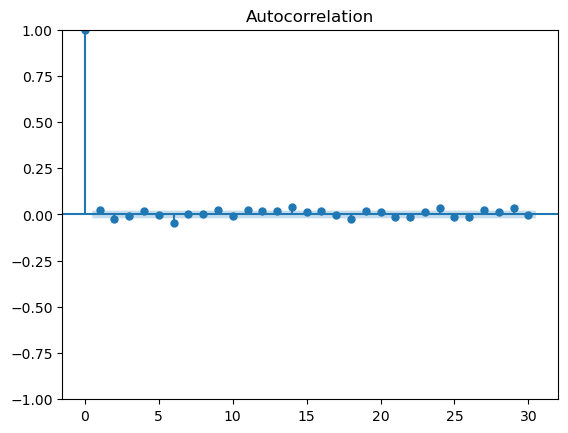

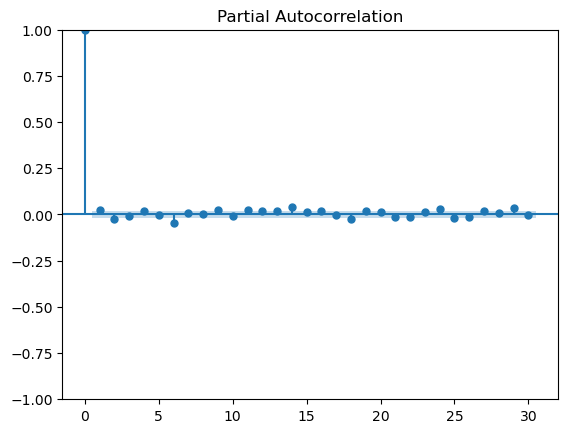

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Price_diff'].dropna(), lags=30)
plt.show()

plot_pacf(df['Price_diff'].dropna(), lags=30)
plt.show()


In [19]:
# For example, assume p=1, d=1, q=1 (these values should come from your analysis)
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()


c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


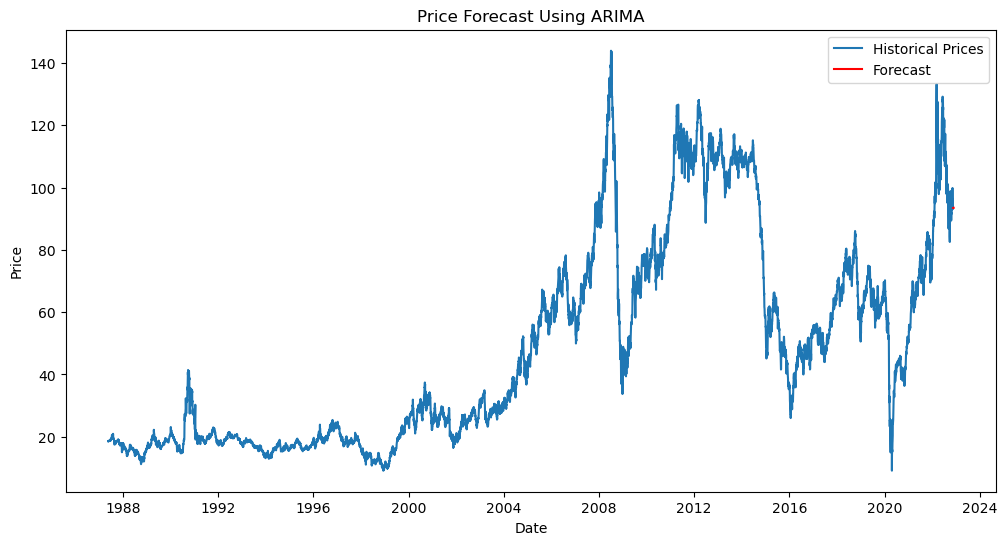

In [20]:
# Forecasting the next 10 time periods
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Prices')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Price Forecast Using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


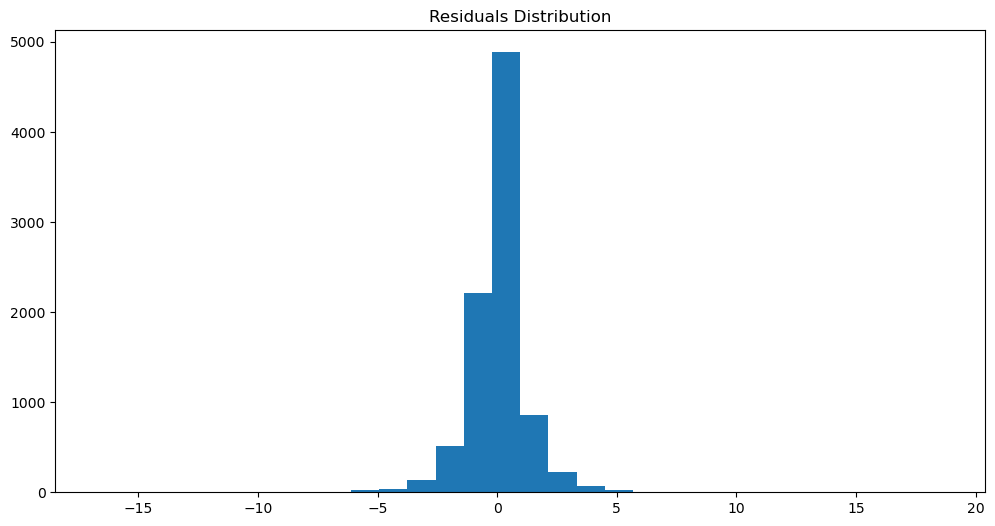

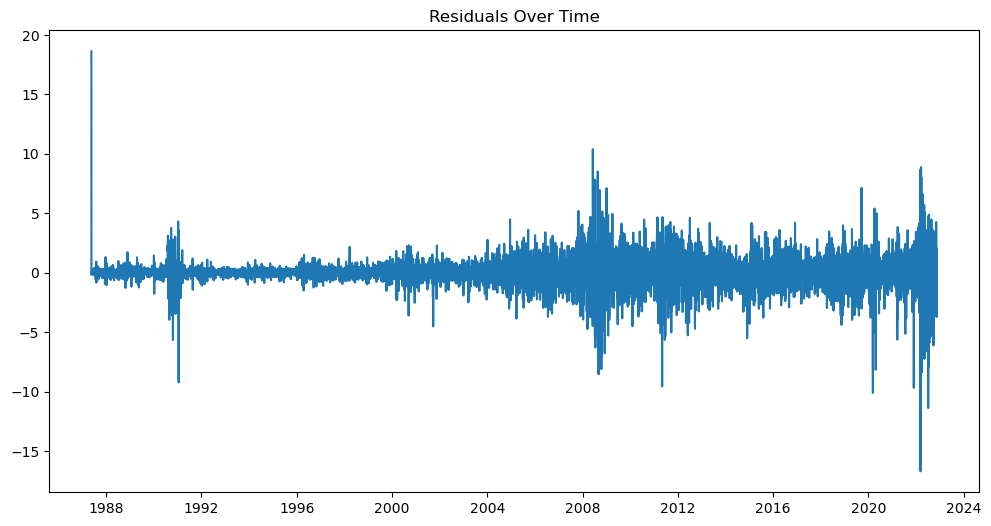

In [21]:
##Model evaluating

residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.show()

# Also, plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.show()



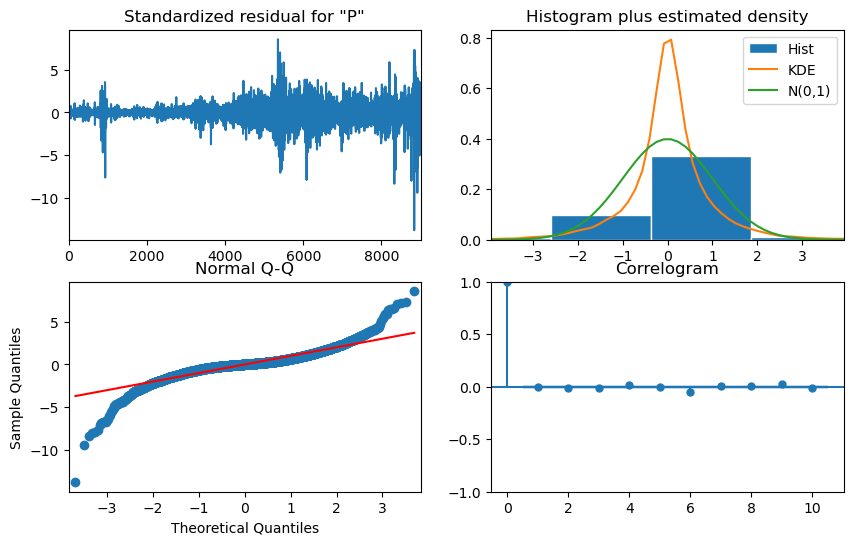

In [23]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.show()
